# GARCH(1,1) Model

Estimation of the parameters is done by creating a grid of different values for the GARCH paramters with the conditions
$\omega, \alpha, \beta > 0$ and $\alpha + \beta < 1$. This is done by creating a grid and iterating through the grid. The maximum likelihood value is calculated for each possible combination of parameters. 

After the highest ML value is found, the grid is refined and a new, smaller, grid is created to ensure that the correct parameters are found. 

In [13]:

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


#Importing Nasdaq data
NDX = yf.Ticker("^NDX")
ndx_data = NDX.history(start="2010-01-01",end="2019-12-31")
price = ndx_data[["Close"]]
price.columns = ["NDX"]
log_returns = np.log(price).diff().dropna()
return_vec = log_returns["NDX"].to_numpy()
#Multiplying returns with 100 to get omega to the same scale as alpha and beta,
#this doesn't have an effect on the value of alpha and beta
return_vec = 100*return_vec
sqrd_returns = np.square(return_vec)

#Setting the initial variance to the average daily variance of the period of the training period
init_var = (1/len(return_vec))*sum((return_vec-np.mean(return_vec))**2)
var_vector = list()


import itertools

#Creating grid
omega_vals = np.linspace(0.001,1,20)
alpha_vals = np.linspace(0.001,1,20)
beta_vals = np.linspace(0.001,1,20)
grid = np.array(list(itertools.product(omega_vals,alpha_vals,beta_vals)))
filtered_grid = grid[grid[:,1]+grid[:,2]<1]


#The refined grid 
def better_grid(omega,alpha,beta,likely):
    omega_vals = np.linspace(omega-0.01,omega+0.01,10)
    alpha_vals = np.linspace(alpha-0.01,alpha+0.01,10)
    beta_vals = np.linspace(beta-0.01,beta+0.01,10)
    grid = np.array(list(itertools.product(omega_vals,alpha_vals,beta_vals)))
    grid = grid[grid[:,1]+grid[:,2]<1]
    #Current highest likelihood value
    likeliest = likely
    for r in range(len(grid)):
        var_vector = list()
        var_vector.append(init_var)
        terms = list()
        for i in range(len(sqrd_returns)-1):
            var = var_vector[i]
            
            #variance for next period
            var_vector.append(grid[r,0]+grid[r,1]*sqrd_returns[i]+grid[r,2]*var)
            #to calculate log-likelihood
            terms.append(np.log(var_vector[i+1])+((sqrd_returns[i+1])/var_vector[i+1]))
        #log-likelihood
        loglik = -0.5*sum(terms)

        #checking if new max is found
        if loglik > likeliest:
            likeliest = loglik
            omega = grid[r,0]
            alpha = grid[r,1]
            beta = grid[r,2]
    final_var = var_vector[-1]
    return [omega, alpha, beta, final_var, likeliest]

#Initial grid search
def minimize(grid):
    for r in range(len(grid)):
        var_vector = list()
        var_vector.append(init_var)
        terms = list()
        for i in range(len(sqrd_returns)-1):
            var = var_vector[i]
            
            var_vector.append(grid[r,0]+grid[r,1]*sqrd_returns[i]+grid[r,2]*var)
            
            terms.append(np.log(var_vector[i+1])+((sqrd_returns[i+1])/var_vector[i+1]))
        #log-likelihood
        loglik = -0.5*sum(terms)
        
        if r == 0:
            #Setting the first likelihood value as the current max
            likeliest = loglik
            omega = grid[r,0]
            alpha = grid[r,1]
            beta = grid[r,2]
            
        else:
            if loglik >= likeliest:
                #testing if a new max likelihood is found
                likeliest = loglik
                omega = grid[r,0]
                alpha = grid[r,1]
                beta = grid[r,2]
    #Initial parameters
    params = [omega,alpha,beta,0,likeliest]
    #Just an "empty" of length 5 that's values will be replaced  
    old_params = [2,2,2,2,2]

    #running the refining grid function until the parameter values don't change by a lot anymore
    while abs(old_params[0]-params[0])>0.001 and abs(old_params[1]-params[1])>0.001 and abs(old_params[2]-params[2])>0.001:
        old_params = params
        params = better_grid(old_params[0],old_params[1],old_params[2],old_params[4])

    return params
                
params = minimize(grid=filtered_grid)
#diving omega by 100000 since we multiplied returns with 100 in the start
params[0] = params[0]/10000
print(f"Omega: {params[0]}, Alpha: {params[1]}, Beta: {params[2]}, log-likelihood: {params[-1]}")
    

Omega: 5.469005847953216e-06, Alpha: 0.12282456140350878, Beta: 0.8300409356725147, log-likelihood: -1229.184120121249


As can be seen, we now have our parameters $\omega, \alpha$ and $\beta$. These will be used to predict the volatility during the period of 2020-01-01 to 2024-01-01.

The prediction of variance for the next time period given by the GARCH(1,1) model is:
$$\hat{\sigma}^2_t = \omega + \alpha Y_{t-1}^2 + \beta \hat{\sigma}^2_{t-1} $$

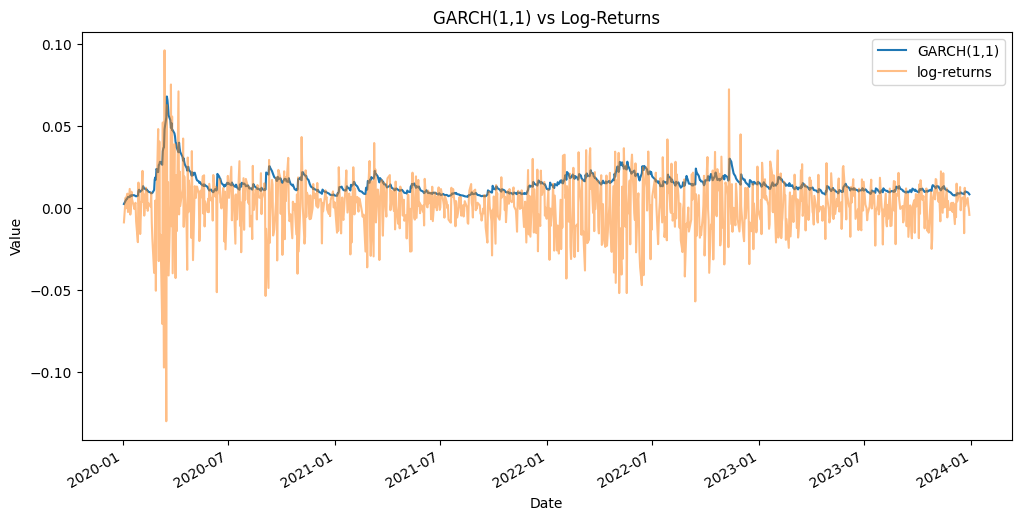

In [33]:
NDX = yf.Ticker("^NDX")
ndx_data2 = NDX.history(start="2020-01-01",end="2024-01-01")
price2 = ndx_data2[["Close"]]
#rescaling the return vector
return_vec = return_vec/100
price2.columns = ["NDX"]
log_returns2 = np.log(price2).diff().dropna()
return_vec2 = log_returns2["NDX"].to_numpy()
sqrd_returns2 = np.square(return_vec2)
pred_var = list()
var_vector = list()


Y = np.square(return_vec[-1])

#Setting first var as the average var of last time period, unscaled
init_var = (1/len(return_vec))*sum((return_vec-np.mean(return_vec))**2)
pred_var.append(init_var)

omega, alpha, beta, var, likelihood = params


def prediction():
    #predicting the variance for each time period
    for i in range(len(return_vec2)):
        if i == 0:
            pred_var.append(omega + alpha*Y + beta*pred_var[i])
        else:
            pred_var.append(omega + alpha*sqrd_returns2[i-1] + beta*pred_var[i])


prediction()
dates = log_returns2.index[0:]

result_df2 = pd.DataFrame({
    "Date": dates,
    "GARCH(1,1)": np.sqrt(pred_var[1:]),
    "log-returns": log_returns2.to_numpy().flatten()[0:]
}).set_index("Date")

# Plot the data
fig, ax = plt.subplots(figsize=(12, 6))
result_df2["GARCH(1,1)"].plot(ax=ax, label="GARCH(1,1)")
result_df2["log-returns"].plot(ax=ax, label="log-returns", alpha=0.5)

# Add labels and title
ax.set_title("GARCH(1,1) vs Log-Returns")
ax.set_ylabel("Value")
ax.set_xlabel("Date")

# Add a legend
ax.legend()

# Show the plot
plt.show()
